<a href="https://colab.research.google.com/github/liapunov/HRdata/blob/master/HRdataNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Salary Predictions Based on Job Descriptions

In [2]:
# We will save and access the data on Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


##Problem definition and context
The purpose of this small project is to apply simple data transformations and machine learning techniques in order to predict the expected salary of people person given a few descriptors such as their job title, their education and their experience.

While the dataset examined here is a heavily simplified data model of a real-world job market, the procedures implemented here should be easily transferable to more complex scenarios and with a richer variety of categories.

## The Data

The data we will work on in this project are:
- 1,000,000 training examples, complete with salary information
- 1,000,000 test examples, with no salary information attached

As we will see when looking at the properties of each feature, at a first look the data seem to have been machine-generated over a uniform distribution. We will expect a lot of noise barring us from predicting the target with very high accuracy. Nevertheless, the data do show some interesting pattern that will eventually drive our hypotheses in building an appropriate model.

Let's start by loading and having a first glance at the data.

In [0]:
# Libraries we are going to use for EDA
import pandas as pd
import seaborn as sb

__author__ = "Francesco Rinarelli"
__email__ = "f.rinarelli@gmail.com"

In [0]:
# Loading the data to cloud storage
#test_feat = pd.read_csv("/content/gdrive/My Drive/data/test_features.csv")
train_feat = pd.read_csv("/content/gdrive/My Drive/data/train_features.csv")
#train_salaries = pd.read_csv("/content/gdrive/My Drive/data/train_salaries.csv")

In [7]:
test_feat.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


As we can see, the features table has eight columns. The first column, jobId, seems to be a key value. We will check that there are no duplicate items in it.

In [0]:
#check for duplicate jobId's
assert train_feat.jobId.nunique() == train_feat.jobId.count()
assert test_feat.jobId.nunique() == test_feat.jobId.count()

*companyId*, *jobType*, *degree*, *major* and *industry* are all categorical features, and they all seem quite self-explanatory. Other two columns, *yearsExperience* and *milesFromMetropolis* are continuous values.

We should perform a few sanity checks on the columns, to see whether there are NA values, or values that are out of the expected range - e.g. negative YearsExperience or milesFrom Metropolis.

In [40]:
# Are there blank values for any of the columns?
if not (train_feat.isnull().values.any() or test_feat.isnull().values.any()):
    print("there are no NA values in both train and test tables")
    
# Are there any blank values in the salaries table?
if not (train_salaries.isnull().values.any()):
    print("there are no NA values in the salaries table")
    
# Check for negative values on continuous features
print(train_feat[train_feat.milesFromMetropolis < 0].values)
print(train_feat[train_feat.yearsExperience < 0].values)
print(train_salaries[train_salaries.salary < 0].values)


there are no NA values in both train and test tables
there are no NA values in the salaries table
[]
[]
[]


It seems that there are no macroscopical errors in the data.

Let's now try to explore more in detail the features. Since there are not so many, a direct approach for each of them will work finely.

In [68]:
# How many unique values for each categorial feature?
test_feat[["companyId", "jobType", "degree", "major", "industry"]].nunique()

companyId    63
jobType       8
degree        5
major         9
industry      7
dtype: int64

There are 63 companies involved, 8 different job titles, 5 levels of education, 9 majors (including the "none" major for employees with no college degree), and 7 industries.

Of course, there must have been an intense work of simplification, as we are only dealing with 7 possible job types, but let's assume this does not affect significantly the expressivity of the data.

We might of course ask whether companies have all the same number of employees. This is an easy check.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


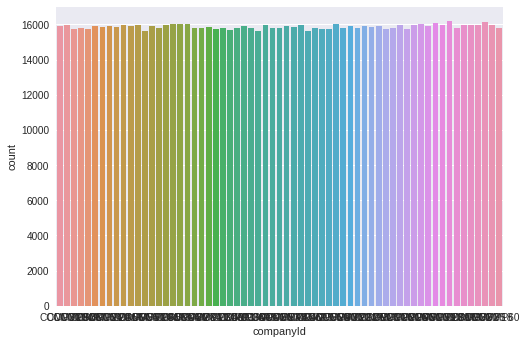

In [69]:
sb.countplot(train_feat.companyId)

It seems that all 63 companies have more or less the same number of employees, which is strange! At least, we can say that company size is probably not going to affect predictions much.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


count     1000000
unique          8
top        SENIOR
freq       125886
Name: jobType, dtype: object

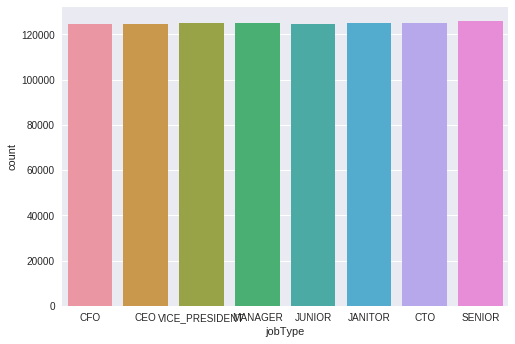

In [70]:
sb.countplot(train_feat.jobType)
train_feat.jobType.describe()

The job titles are also, curiosly, evenly distributed. Indeed, we can verify the same with industry, yearsExperience and milesFromMetropolis.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


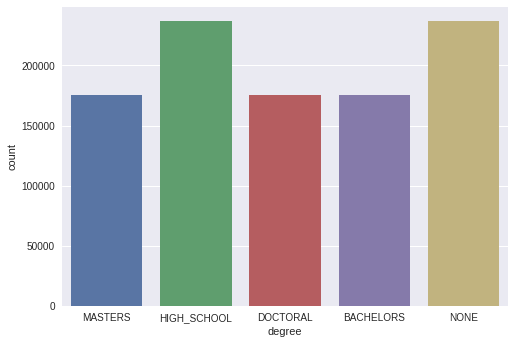

In [76]:
sb.countplot(train_feat.degree)

Degree and major are different. Both are biased towards the lower levels of education, with NONE being around ten times more frequent than all other majors and "high school" and "none" being the most frequent values among the *degree* categories.

How are *degree* and *major* correlated?

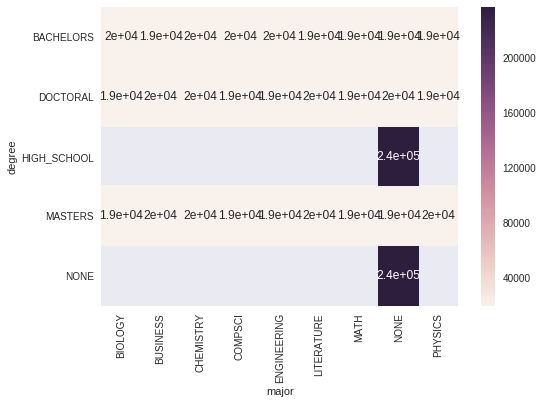

In [94]:
pivot = train_feat[["degree","major"]].pivot_table(index="degree",columns="major", aggfunc=len)
sb.heatmap(pivot, annot=True)

As expected, all employees with no degree or just high-school education will have "none" as major, but the reverse is not true: "none" seems to be just as likely as any other major value for all the higher education levels.

Let's now have a look at the salary. Hopefully, it is not uniformly distributed as many of the features.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


NormaltestResult(statistic=18943.965939478327, pvalue=0.0)


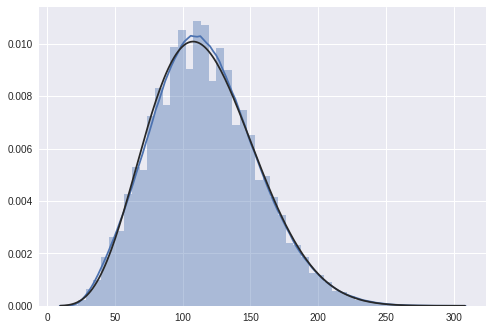

In [0]:
#How are salary distributed in general? Let's fit the series with a Beta distribution
from scipy.stats import norm, beta, normaltest
sb.distplot(tuple(train_salaries.salary), fit=beta)
#check for normality
print(normaltest(train_salaries.salary))

As we can see, salaries seems to be distributed with a central distribution. Performing a simple normality test makes us exclude the hypothesis that salaries are normally distributed - they possibly follow a beta distribution with a good amount of right skeweness - relatively many very high salaries.

###Relation of the features with the target

We can now move to explore in some detail the possible relations of each of the features with the salary. We hope to extract some useful information in order to formulate an educated hypothesis on the models to consider for the prediction.

Let's start by creating a joint table for features and the salary.

In [0]:
#For practical convenience of EDA, let's unite the features and the target
train_feat_salary = pd.merge(train_feat,train_salaries,how="left",on="jobId")

In [0]:
train_feat_salary.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


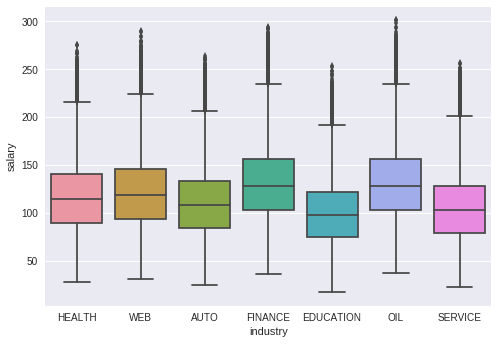

In [11]:
# Distributions of salaries over features can also be synthetically checked with boxplots,
# in which it is easier to show whether a particular value of the features has a significantly
# different mean or variance.
sb.boxplot(x="industry",y="salary",data=train_feat_salary)

In [0]:
# Kruskal/Wallis nonparametric omnibus test, just to check whether
# the differences seen above are significant
from scipy.stats import kruskal

#split the salary columns into different series by industry
salary_industry_arr = []
for ind in train_feat_salary["industry"].unique():
    salary_industry_arr.append(train_feat_salary[train_feat_salary.industry==ind].salary.values)

#run the K/W test
kruskal(*salary_industry_arr)

KruskalResult(statistic=83284.30288773228, pvalue=0.0)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


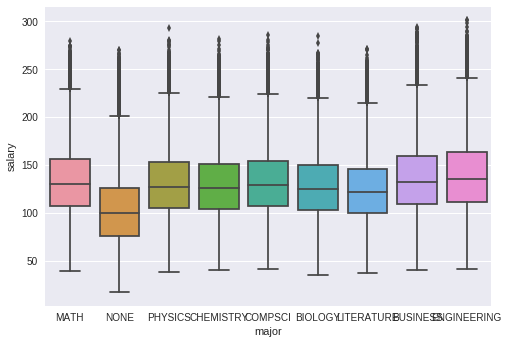

In [8]:
sb.boxplot(x="major",y="salary",data=train_feat_salary)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


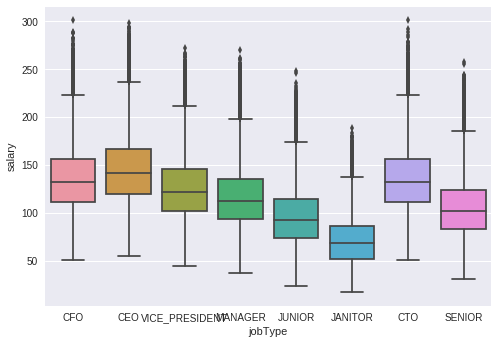

In [15]:
sb.boxplot(x="jobType",y="salary",data=train_feat_salary)

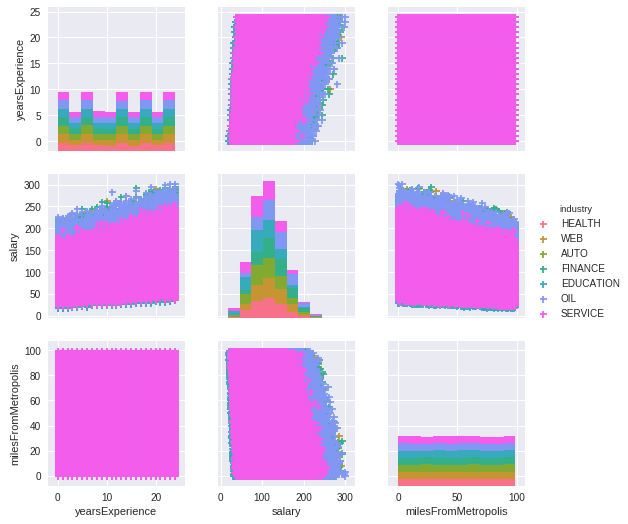

In [0]:
# We could try to extract more information from pair plots,
# for example by checking whether there are any relations between
# continuous variables and controlling by degree or industry
sb.pairplot(train_feat_salary, hue="industry", vars=["yearsExperience","salary","milesFromMetropolis"], markers="+")

###Defining a valid reference point for performance evaluation

We need to establish a baseline in order to understand what value a ML model is adding to the processes of a typical company that might use salary data like these.

In this case, we can assume that an hypothetical company owning the current dataset has already created **relatively simple tables** with the average salary for a certain number of clusters of jobs.

How to choose which segments are relevant to build such a table?
Again, we are assuming that the table size must be a *good compromise between accuracy and usability* - we do not want to manage thousands of different segments.

Based on the box plots above, we see that a good part of the variance seems to be explained by the differences in **Job Title** and in **Industry**. Of course, having a major in STEM versus not having a degree also seems to have statistically significant effects, but we do not want to make the reference table unwieldy for the users.

Let's try then to create a reference table of salaries by industry and job title. This should result in a 7x8 table, simple enough for manual consultation.

In [11]:
# We create a toy model based on what we have seen before.
# We will ignore the slight cap effect of experience and distance from the city for now.
# We will use a 8x7 table created by crossing the major with the industry

# We will use the Mean Squared Error to assess the performance of the model,
# through a 5-fold crossvalidation
import numpy as np
from sklearn.model_selection import KFold

five_fold_cv = KFold(n_splits=5, shuffle=True)

MSE = 0

# TRAINING/VALIDATION FOLD
for i in range(5):
    split = next(five_fold_cv.split(train_feat_salary))
    this_train_set = train_feat_salary.iloc[split[0]][["jobType","industry","salary"]]
    this_valid_set = train_feat_salary.iloc[split[1]][["jobType","industry","salary"]]
    
    # "TRAINING"
    # create the table-model (n major values x m industry values)
    ref_table = this_train_set.groupby(["jobType","industry"])["salary"].mean().reset_index()

    # "VALIDATION"
    # split the validation set in features and target
    # then estimate the salary based on the table above
    valid_salary = this_valid_set.pop("salary").values
    est_salary = this_valid_set[["jobType","industry"]].merge(ref_table, how="left").salary.values
        
    MSE += np.mean((valid_salary - est_salary)**2)

# Calculate the average MSE of the 5-fold CV
baseline_MSE = MSE/5
print(baseline_MSE)

834.8895481638692


As we can see, using a relatively simple reference table, which does not even use all of the features, we are able to obtain a Mean Square Error of slightly above 800. Roughly speaking, we should expect to guess a salary within a range of +/- 29k dollars, which is the square root of the error.

Is it good enough? A heuristic metrics to judge the goodness of this error could be to compare the root mean squared error with the standard deviation of salary for the general population:

In [14]:
np.sqrt(baseline_MSE)/valid_salary.std()

0.7461937828438913

The RMSE is 74% of the standard deviation. This is of course an improvement, but definitely not a major one. Can we do better, say at least below 50%? This would correspond to a MSE of around 370.

In [19]:
(0.5*valid_salary.std())**2

374.85713397144315

##Looking for better solutions

The table-based model above (with only about 60 parameters) performs decently with a validation MSE just above 1000, but clearly it makes not use of several features in the model, most notably:
1. linear cap effects of experience (ascending) and distance from the city (descending)
2. peculiarities of each company
3. job seniority
In fact, it does not take into account any feature interaction other than the couple major/industry.

With 1 million rows and virtually no unbalances in the value distributions for each feature, the dataset is robust enough to be attacked with several high bias learning algorithms, including neural networks, with sufficient regularization.
Other choices might include:
 - Linear regression models, possibly regularized models such as Lasso or Ridge. This has the advantage of having minimal training times, but we expect a higher bias
 - Decision (regression) trees regressors, in particular in ensemble (e.g. Random Forests). This class of models is known to perform fairly well on a wide range of problems

It might be useful to consider the nature of the dataset, which has mixed categorical/numerical features.
Using neural networks, kNNs or random forests through sklearn requires transforming the categorical variables into dummy variable or one-hot encoded factors.
If you want to preserve categories as they are and use RF, you might avail of H20, which boasts one of the fastest RF algorithms and can handle categories natively. (http://docs.h2o.ai)

We will keep on with sklearn and proceed to engineer our dataset this time.

### Engineering features

Considering the three models we are going to test, and the number of training examples, we could operate two simple transformations:

1.  **"Dummify" the categorical features**: transform each categorical variable into binary features. Since we are going to use linear models such as Lasso and Ridge, to minimize the risk of multicollinearity it is better to use a dummy strategy, that is, reduce the number of features into n-1 categories, so that the nth is not construed as the linear combination of the others (regularization should take care of this problem already, to some extent)
2.  **Normalize the features**: with the exception of the dummies, all the continuous features. It is not necessary to normalize the target value (why? See [here](https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re)) 

After applying these transformations, we can finally detach the salary into the target, to be fed into our models.

An important action we should take before experimenting with our models is to prepare a small validation set. Even if we are going to use cross-validation for Random Forests and Lasso/Ridge, it is safer to reserve  small portion of the data to have a final validation with examples that have not been used for parameter tuning.
Of course, we *are not going to use the validation score to adjust parameters*. It will be the final, official score of each model.

In [25]:
# One-hot encoding pure categorical data
train_feat_salary = train_feat_salary.copy()
for feat in ["jobType","degree","major","companyId","industry"]:
    train_feat_salary = pd.concat([train_feat_salary, pd.get_dummies(train_feat_salary[feat])],axis=1)
    train_feat_salary = train_feat_salary.drop(columns=[feat])
train_feat_salary.head()

,jobId,yearsExperience,milesFromMetropolis,salary,CEO,CFO,CTO,JANITOR,JUNIOR,MANAGER,...,COMP7,COMP8,COMP9,AUTO,EDUCATION,FINANCE,HEALTH,OIL,SERVICE,WEB
0,JOB1362684407687,10,83,130,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,JOB1362684407688,3,73,101,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,JOB1362684407689,10,38,137,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,JOB1362684407690,8,17,142,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,JOB1362684407691,8,16,163,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [26]:
# Normalizing the continuous variables;
for feat in ["yearsExperience","milesFromMetropolis"]:
    train_feat_salary[feat] = (train_feat_salary[feat]-\
                                  train_feat_salary[feat].mean())/train_feat_salary[feat].std()
train_feat_salary.head()

,jobId,yearsExperience,milesFromMetropolis,salary,CEO,CFO,CTO,JANITOR,JUNIOR,MANAGER,...,COMP7,COMP8,COMP9,AUTO,EDUCATION,FINANCE,HEALTH,OIL,SERVICE,WEB
0,JOB1362684407687,-0.276248,1.159046,130,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,JOB1362684407688,-1.246800,0.812759,101,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,JOB1362684407689,-0.276248,-0.399248,137,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,JOB1362684407690,-0.553548,-1.126452,142,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,JOB1362684407691,-0.553548,-1.161081,163,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [0]:
# Now we can detach the target (salary) from the features
train_salaries = train_feat_salary.salary
train_feat_norm = train_feat_salary.drop(columns=["salary","jobId"])


# Since we are going to perform many cross/validated tests to tune the model,
# it is recommendable to keep a few samples for a final validation
from sklearn.model_selection import train_test_split

train_feat_norm, val_feat_norm, train_salaries, val_salaries = train_test_split(train_feat_norm,\
                                                                                train_salaries,\
                                                                               test_size=0.1)

###Let's initialize the models

As mentioned above we will initialize and tune three families of models:
1. **Regularized linear models**: they are simple, yet robust methods that can deal with numerous features and generalize better than the standard linear regression. The main parameter to set here is alpha, that is, the coefficient of the regularization component in the loss function.
2. **Random Forests**: this powerful, relatively simple family of models builds on decision trees and learns an ensemble of weak predictors (regressors) to improve generalization while keeping bias low. With Random Forests, we are going to experiment on a couple of parameters: the *maximum depth* of each weak learner/tree, and the number of trees that the algorithm needs to build. Of course, increasing too much max_depth and n_estimators is going to damage generalization and increase the learning time.
3. **Neural Networks**: we will try applying a somewhat vanilla-variety of this powerful family of models. Neural network work very well with many data rows (provided one has the computing power) and have less problems than other models in keeping bias and variance on check, but the number of parameters that needs to be tuned is high, with several nonlinear interferences between one parameter and the others. We will use **Keras** to build a sequential network and try to keep as many defaults as possible.

First, we build our linear regressors. Lasso and Ridge are regularized versions of the classical linear regression. The difference between the two is that Lasso utilizes a L1 regularization (the penalty factor is directly proportional to the weights) while Ridge features a L2 regularization (the penalty and the weights are quadratically related). The practical difference is that Lass tends to create a model with less non-zero features overall. 
For more information: https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/

In [0]:
# Using sklearn Linear_model library to instantiate Lasso and Ridge regressor
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
from sklearn.linear_model import Lasso, Ridge
# These values of alpha worked reasonably well
Lasso_reg = Lasso(alpha=0.1)
Ridge_reg = Ridge(alpha=0.1)

Next, we build our RF model.
Of course, we are using a RF *regressor*, which means that the model will spout the level of the output based on the votes of the ensemble learners/trees (which themselves are spouting the mean of the values included in the specific decision segment for each tree).

Although sklearn offers different parameters to tune, we will make do with the above-mentioned two: max_depth and n_estimators.

For a beautifully, fully worked out example: https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/

In [0]:
#Using sklearn Ensemble library to initialize a regressor
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
from sklearn.ensemble import RandomForestRegressor

# These are the parameters that worked better. 
RF_reg = RandomForestRegressor(n_estimators=70, max_depth=20, n_jobs=-1, verbose=3)

Finally, we implement a simple Neural Networks through Tensorflow and Keras. As the model seems relatively low-dimensional and static, we will build a sequential network with a limited number of layers. Of course the depth of the network as well as the number of neurons per layer will be subject to tuning and validation.

Other than that, we might look into the optimizer to see whether tweaking the learning rate will have some positive effect. We will use Adam as it is relatively stable and most of its parameters can be left alone. Note that we will avail of dropout and batch normalization to respectively regularize the network and improve the accuracy of the final layers.

In [0]:
import tensorflow as tf
from keras.models import Sequential
from keras.activations import relu
from keras.layers import Dense, Dropout, BatchNormalization

my_NN = Sequential([
    Dense(90, activation="elu", input_shape=(94,)),
    Dropout(0.1),
    Dense(60, activation="elu"),
    Dropout(0.1),
    Dense(40, activation="elu"),
    Dropout(0.1),
    Dense(1, activation="linear"),
    ])

### ---- 9 Test models ----

In [0]:
#do 5-fold cross validation on models and measure MSE
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, make_scorer

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [44]:
Lasso_scores = cross_validate(Lasso_reg, train_feat_norm, train_salaries,\
                        scoring=mse_scorer ,cv=5, return_train_score=True,\
                        return_estimator=True, verbose=4, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.1s finished


In [45]:
Ridge_scores = cross_validate(Ridge_reg, train_feat_norm, train_salaries,\
                        scoring=mse_scorer ,cv=5, return_train_score=True,\
                        return_estimator=True, verbose=4, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.5s finished


In [0]:
RF_scores = cross_validate(RF_reg, train_feat_norm, train_salaries,\
                        scoring=mse_scorer ,cv=5, return_train_score=True,\
                        return_estimator=True, verbose=4, n_jobs=-1)

In [35]:
from keras.optimizers import Adam
#my_opt = Adam(lr=0.01, beta_1=0.96, beta_2=0.99)
my_NN.compile(optimizer="adam", loss="mse")
my_NN.fit(train_feat_norm, train_salaries, validation_split=0.1, epochs=20, batch_size=40)

Train on 809995 samples, validate on 90000 samples
Epoch 1/20
809995/809995 [==============================] - 57s 70us/step - loss: 489.1018 - val_loss: 363.4010
Epoch 2/20
809995/809995 [==============================] - 56s 69us/step - loss: 417.6898 - val_loss: 359.1911
Epoch 3/20
809995/809995 [==============================] - 58s 72us/step - loss: 412.2514 - val_loss: 359.6924
Epoch 4/20
809995/809995 [==============================] - 56s 69us/step - loss: 409.0906 - val_loss: 358.1895
Epoch 5/20
809995/809995 [==============================] - 56s 69us/step - loss: 406.8404 - val_loss: 359.7843
Epoch 6/20
809995/809995 [==============================] - 56s 69us/step - loss: 404.2897 - val_loss: 357.1469
Epoch 7/20
809995/809995 [==============================] - 57s 70us/step - loss: 402.1765 - val_loss: 356.7089
Epoch 8/20
809995/809995 [==============================] - 59s 73us/step - loss: 400.2501 - val_loss: 356.6801
Epoch 9/20
809995/809995 [===========================

In [48]:
#RF_est = RF_scores["estimator"][0]
#RF_train_score = RF_scores["test_score"].mean()
Lasso_train_score = Lasso_scores["test_score"].mean()
Ridge_train_score = Ridge_scores["test_score"].mean()

#print(RF_train_score)
print(Lasso_train_score)
print(Ridge_train_score)

-386.58604911068596
-384.22207380143004


### ---- 10 Select best model  ----

In [26]:
mean_squared_error(train_salaries,this_Lasso_est.predict(train_feat_norm))

384.98703497873436

In [38]:
my_NN.evaluate(val_feat_norm,val_salaries)

100000/100000 [==============================] - 3s 30us/step


359.45495004882815

In [0]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [0]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [0]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data